In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

from tqdm.notebook import tqdm

import os
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
max_seg_length = 4000

src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/modified_network_{max_seg_length}.gpkg"
dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"

land_cover_paths = {2000: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2000_fi25m/Clc2000_main_classes_hydro.tif", 
                    2006: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2006_fi25m/Clc2006_main_classes_hydro.tif",
                    2012: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2012_fi20m/Clc2012_main_classes_hydro.tif",
                    2018: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2018_fi20m/Clc2018_main_classes_hydro.tif"
                   }

watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

lc_classes = {1 : "urban", 2 : "agriculture", 3 : "forest", 4 : "peatland", 5: "water"}

# Land cover

In [42]:

def add_lc_to_subwatersheds(subwatersheds, land_cover_path, lc_classes, year):
    """
    Adds land cover classification proportions of a spesific year to subwatersheds.

    Parameters:
    subwatersheds (GeoDataFrame): A GeoDataFrame containing subwatershed geometries and attributes.
    land_cover_path (str): Path to the land cover raster file.
    lc_classes (dict): A dictionary mapping land cover class values to their names.
    year (int): The year of the land cover data.
    bounds (tuple): A tuple containing the bounding box coordinates (minx, miny, maxx, maxy).

    Returns:
    GeoDataFrame: The input GeoDataFrame with additional columns for each land cover class proportion.
    """
    place_id = subwatersheds.at[0, 'Paikka_Id']

    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        minx = subwatershed.bounds.at[0, 'minx']
        miny = subwatershed.bounds.at[0, 'miny']
        maxx = subwatershed.bounds.at[0, 'maxx']
        maxy = subwatershed.bounds.at[0, 'maxy']

        with rasterio.open(land_cover_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
        profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
        profile['width'] = values.shape[1]
        profile['height'] = values.shape[0]
        
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
        
        area = area_mask.sum()
        
        clipped_values = np.where(area_mask == 1, values, 0)
        for key in lc_classes:
            class_name = lc_classes[key]
            class_values = np.where(clipped_values == key, 1, 0)
        
            class_area = class_values.sum()
    
            # Some subwaterhseds cause minor problems 
            warnings.filterwarnings("error")
            
            try:
                class_portion = class_area / area
    
            except:
                class_portion = 0
                print(f"{class_name}_portion was set to zero for watershed {place_id}, subwatershed {j} because {class_area} or {area} were invalid features")
            warnings.filterwarnings("default")
            
            
            subwatersheds.at[j, f"{class_name}_portion_{year}"] = class_portion

    return subwatersheds

In [38]:
test_selection = 150

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue

    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']

    for year in land_cover_paths:
        pbar.set_description(f" Doing land cover of {year} for catchment {i}")
        land_cover_path = land_cover_paths[year]
        subwatersheds = add_lc_to_subwatersheds(subwatersheds, land_cover_path, lc_classes, year)

    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    if i == test_selection:
        break

  0%|          | 0/167 [00:00<?, ?it/s]

87 16187
3 16187
13992 16187
949 16187
1053 16187
396 14371
140 14371
11459 14371
582 14371
1402 14371
366 23987
660 23987
20638 23987
835 23987
1035 23987
557 10569
1228 10569
7709 10569
165 10569
608 10569
919 20164
2596 20164
11857 20164
393 20164
3905 20164
131 7635
254 7635
6607 7635
190 7635
367 7635
1439 40405
2653 40405
33761 40405
685 40405
1360 40405
100 16187
1 16187
14256 16187
581 16187
1180 16187
375 14371
116 14371
11677 14371
365 14371
1539 14371
360 23987
782 23987
20978 23987
454 23987
1092 23987
545 10569
1295 10569
7625 10569
164 10569
638 10569
933 20164
2735 20164
11729 20164
366 20164
3977 20164
150 7635
273 7635
6582 7635
135 7635
413 7635
1701 40405
2867 40405
33292 40405
571 40405
1556 40405
86 25032
4 25032
21959 25032
1051 25032
1858 25032
295 22102
80 22102
18425 22102
564 22102
2413 22102
336 37045
774 37045
33233 37045
558 37045
1768 37045
413 16222
1772 16222
12581 16222
124 16222
981 16222
863 31276
3687 31276
19428 31276
1083 31276
5714 31276
124 11654

In [39]:

subwatersheds

,Paikka_Id,main_basin_index,area_m2,id,pituus_m,next,pour,dam,in_connect,lake,...,urban_portion_2012,agriculture_portion_2012,forest_portion_2012,peatland_portion_2012,water_portion_2012,urban_portion_2018,agriculture_portion_2018,forest_portion_2018,peatland_portion_2018,water_portion_2018
0,1159,87,9811500.0,46,2162.846004,42,False,False,0,True,...,0.003436,0.000160,0.877237,0.041986,0.074225,0.003396,0.000080,0.890340,0.031879,0.071349
1,1159,87,8629000.0,42,4189.809565,0,False,False,1,False,...,0.013347,0.003620,0.833635,0.025518,0.109176,0.013347,0.002760,0.844358,0.017284,0.107637
2,1159,87,14606100.0,0,3864.314117,16,False,False,1,True,...,0.009070,0.020894,0.897098,0.015063,0.047726,0.009070,0.019949,0.897341,0.015090,0.048374
3,1159,87,6400400.0,16,2752.539256,28,False,False,1,True,...,0.025459,0.109234,0.775552,0.007644,0.060473,0.026631,0.104858,0.778449,0.009617,0.059302
4,1159,87,12245800.0,39,NaN,39,True,False,2,True,...,0.027593,0.117886,0.621179,0.034627,0.182696,0.026730,0.112802,0.628437,0.026538,0.189027
5,1159,87,4578100.0,4,7854.434258,28,False,False,0,True,...,0.010640,0.030033,0.881242,0.014330,0.055517,0.010125,0.029003,0.888279,0.012614,0.051742
6,1159,87,24544500.0,28,4981.136426,39,False,False,2,True,...,0.028182,0.061601,0.847183,0.015572,0.039820,0.027449,0.057398,0.853010,0.015365,0.039152


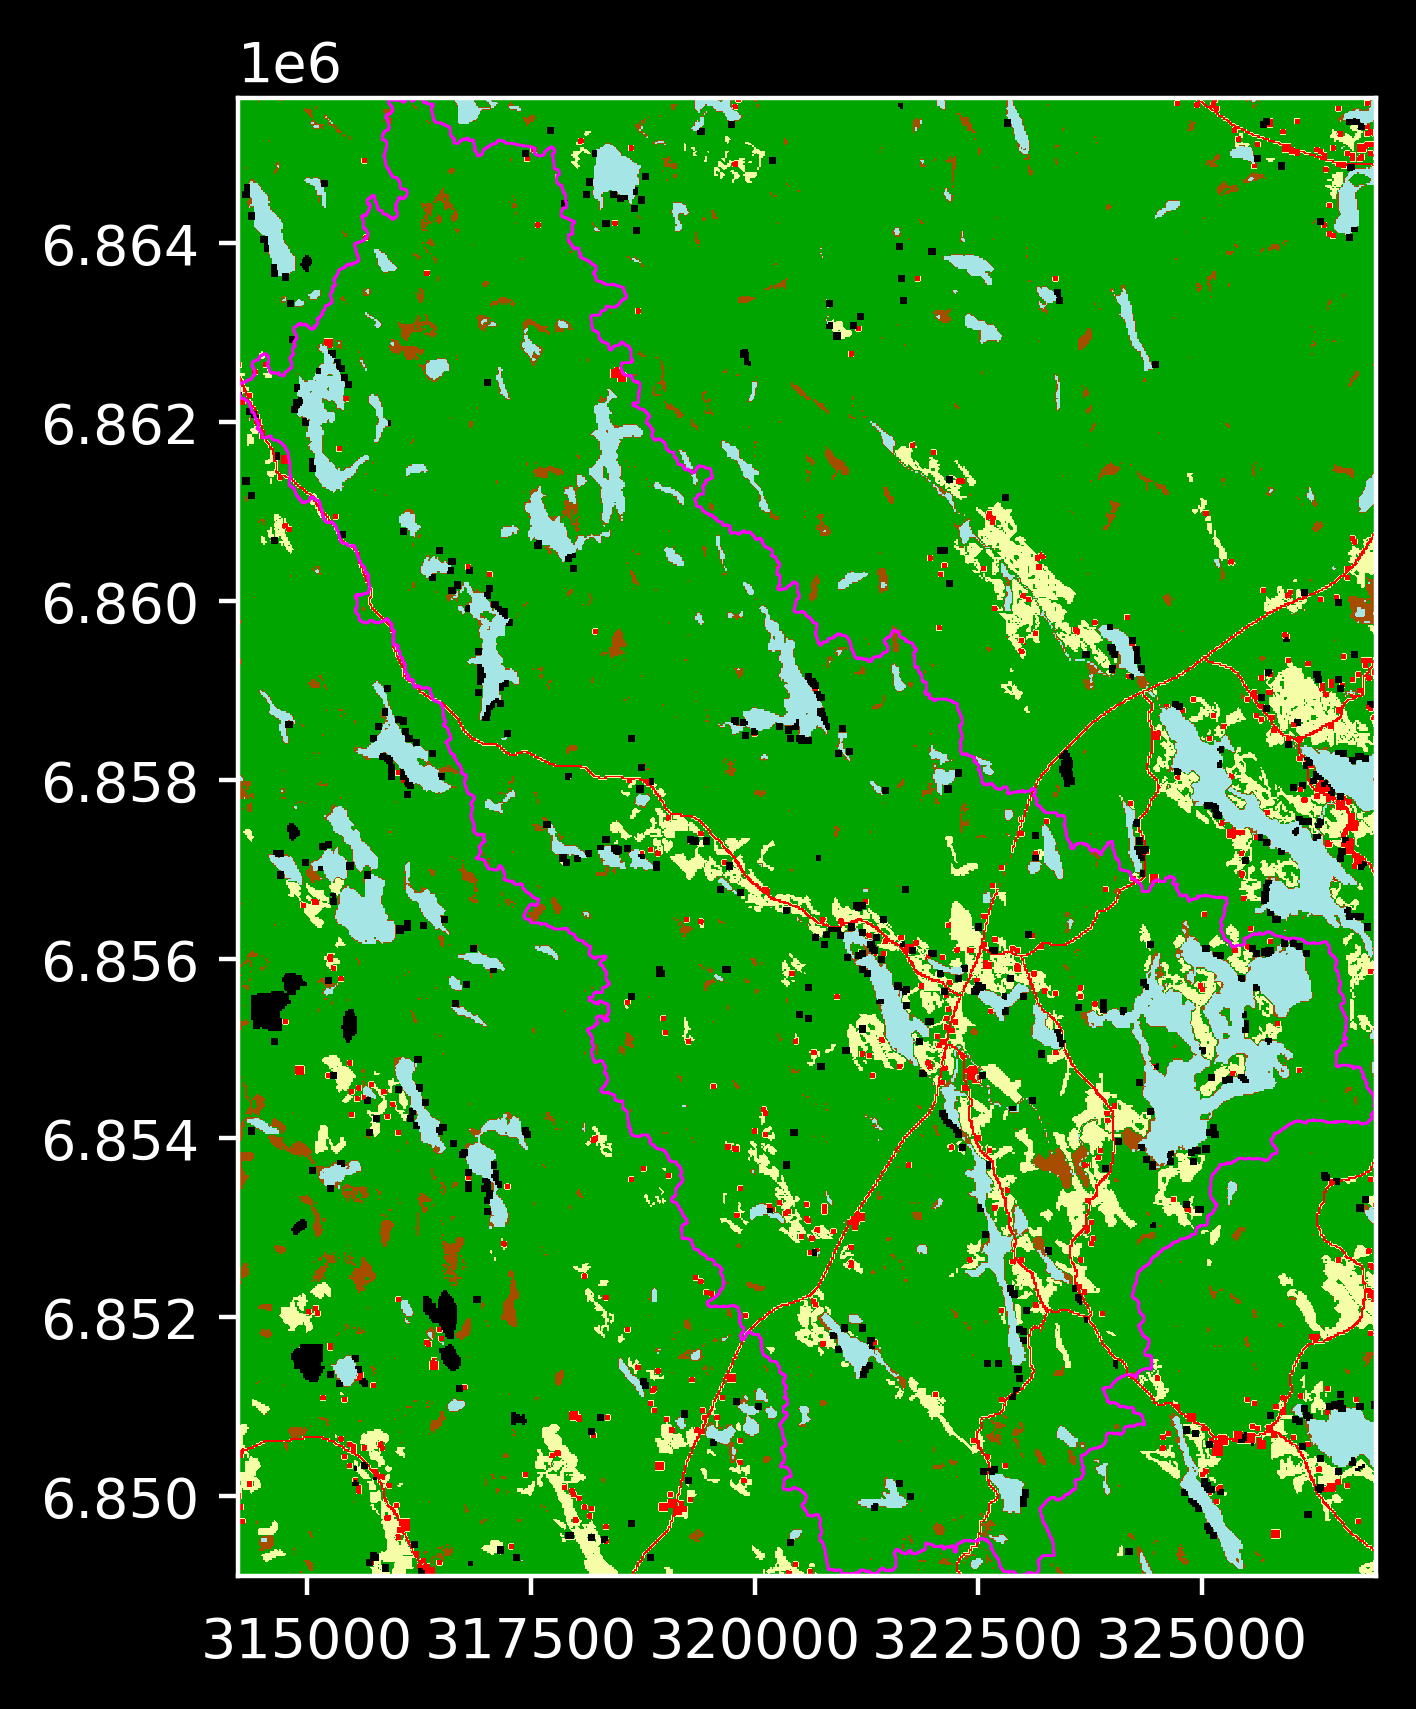

In [40]:
with rasterio.open(land_cover_path) as src:
    profile = src.profile
    values = src.read(
        1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
        boundless=True, fill_value=profile['nodata'])
    
profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
profile['width'] = values.shape[1]
profile['height'] = values.shape[0]
# For visualization
masked_values = ma.masked_values(values, profile['nodata'])
    


cmap = ListedColormap(["#fe0000", "#f5fea7", "#00a500", "#a64d00", "#a5e5e5"])

fig, ax = plt.subplots()
show(masked_values, transform=profile['transform'], ax=ax, cmap=cmap)
#show(class_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
#show(clipped_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
ax = watershed.boundary.plot(ax=ax, color='fuchsia', linewidth=0.5)



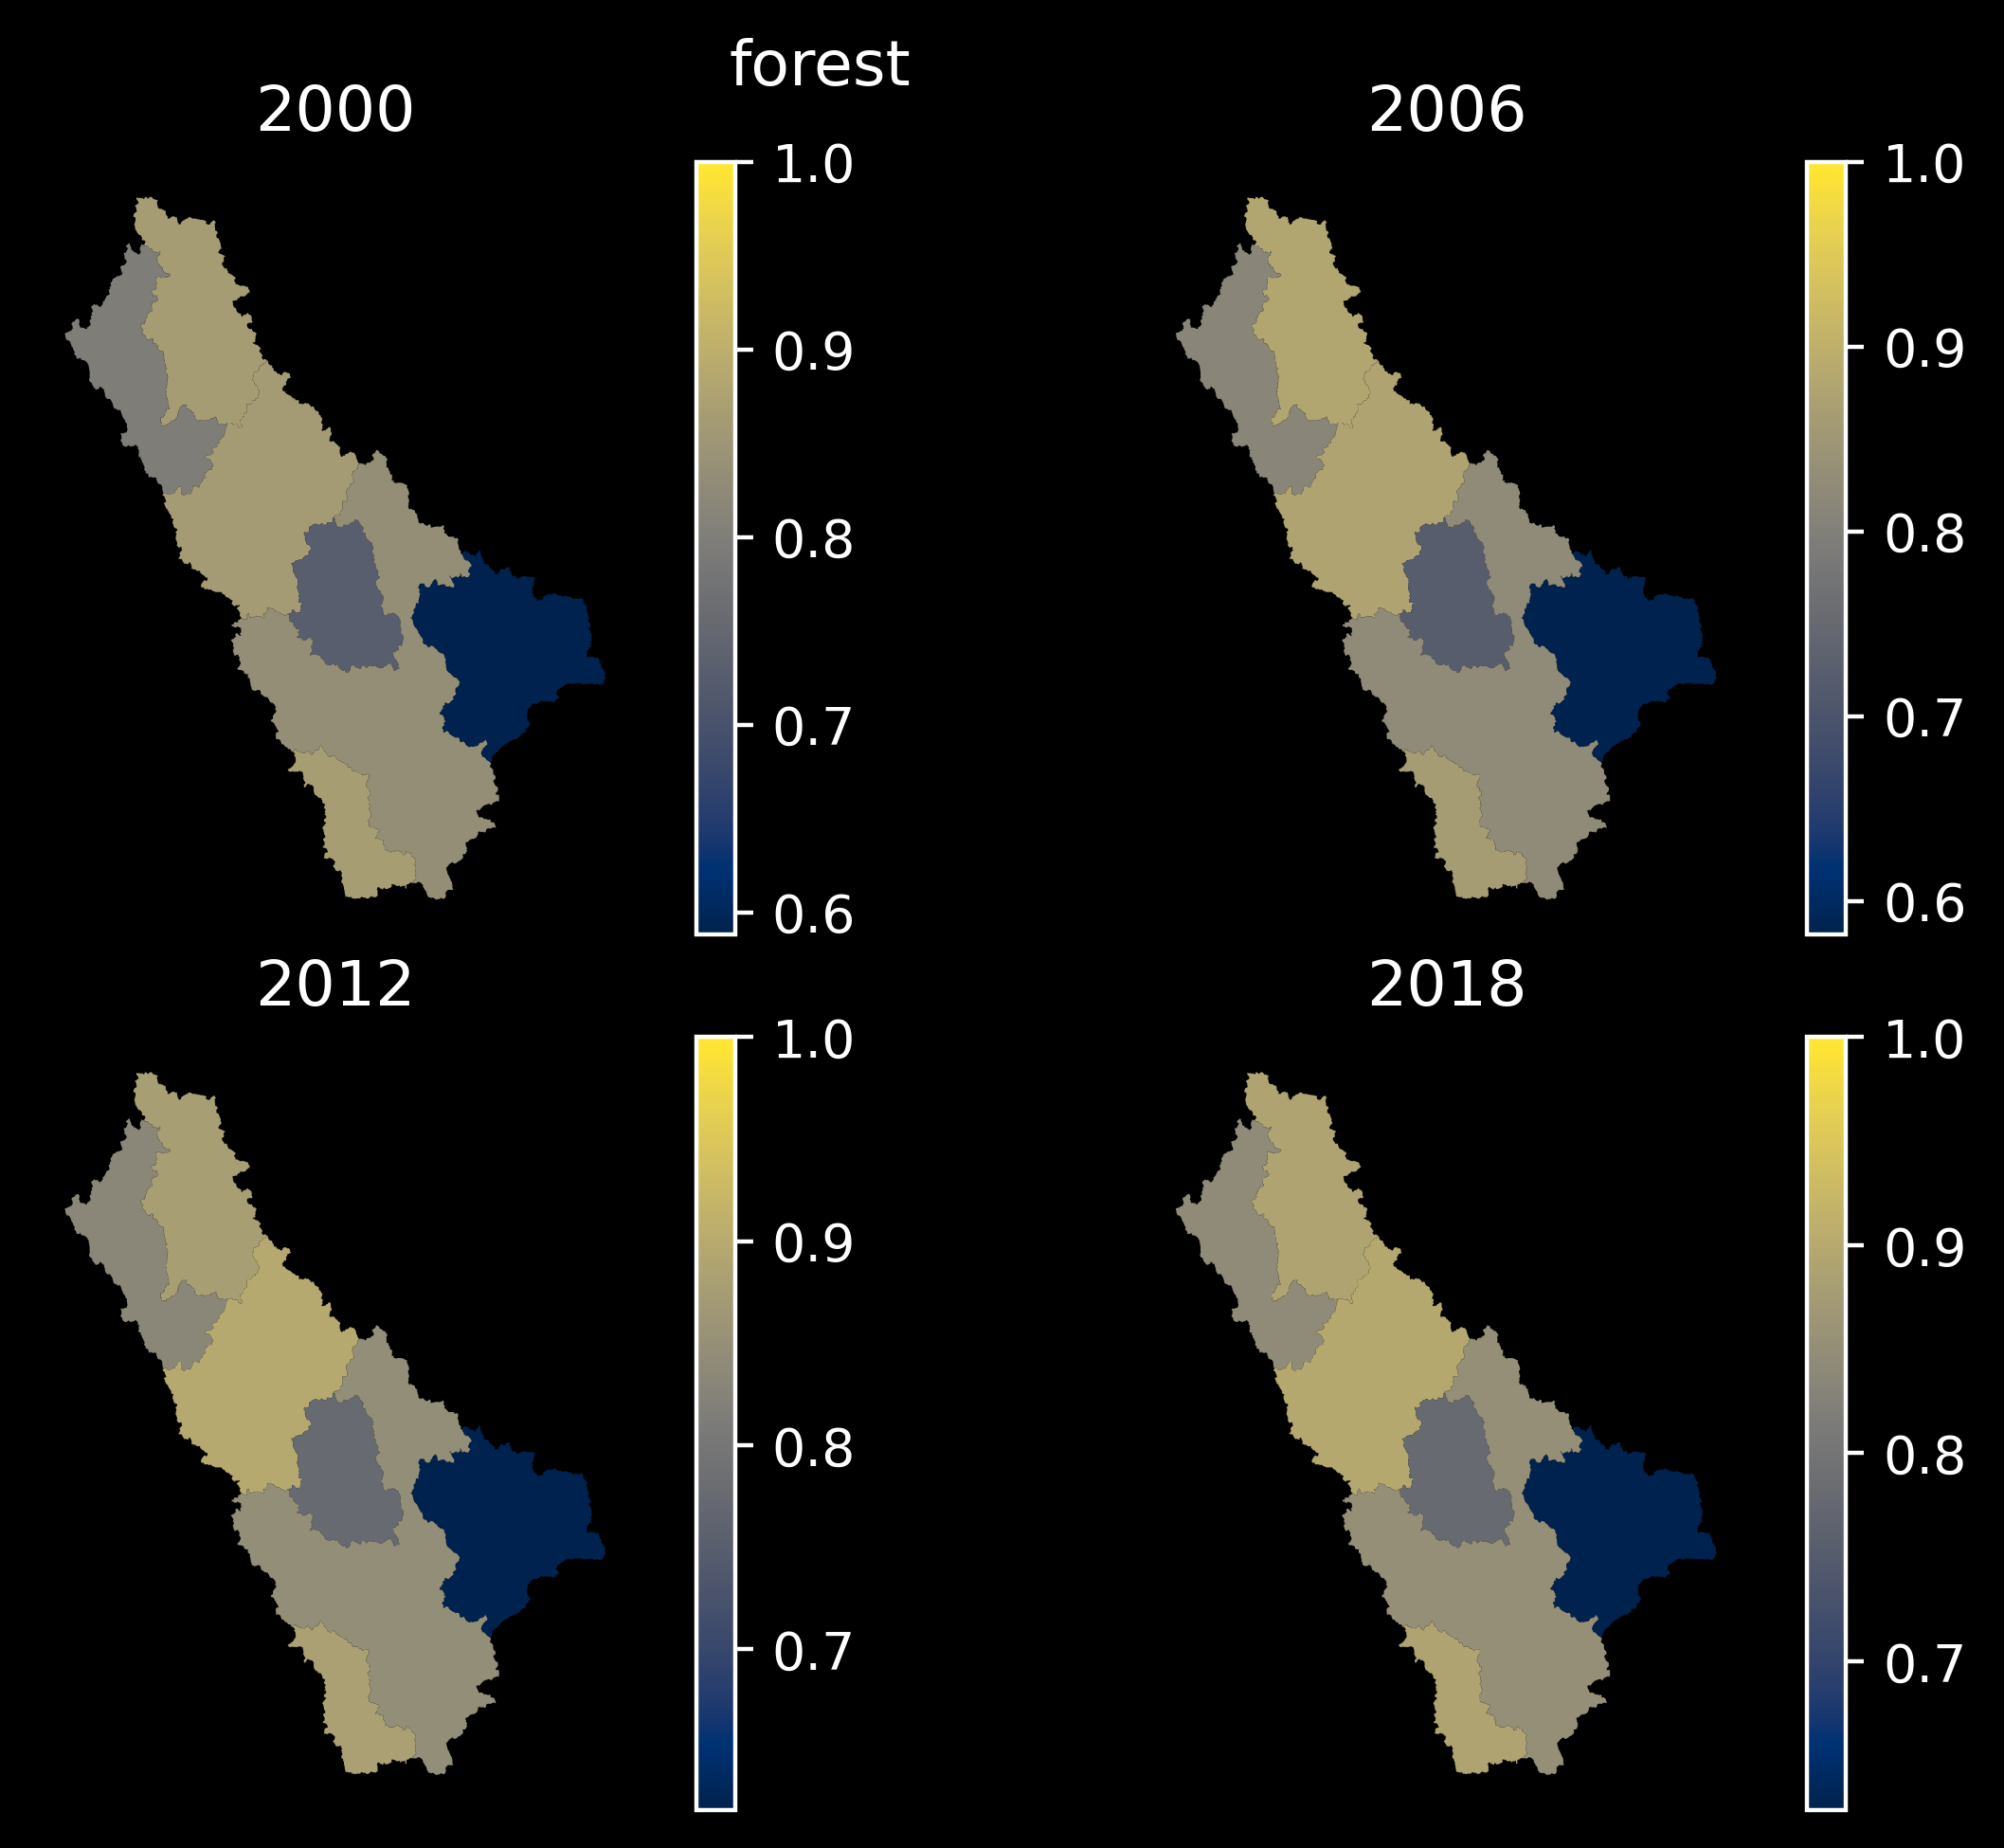

In [41]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
vmax = 1
lc_class = "forest"
fig.suptitle(lc_class)
ax1 = subwatersheds.plot(f"{lc_class}_portion_2000",ax=ax1, markersize=0.2, cmap='cividis', vmax=vmax, legend=True)
ax1.set_axis_off()
ax1.set_title(2000)

ax2 = subwatersheds.plot(f"{lc_class}_portion_2006", ax=ax2, markersize=0.2, cmap='cividis',  vmax=vmax, legend=True)
ax2.set_axis_off()
ax2.set_title(2006)

ax3 = subwatersheds.plot(f"{lc_class}_portion_2012", ax=ax3, markersize=0.2, cmap='cividis', vmax=vmax, legend=True)
ax3.set_axis_off()
ax3.set_title(2012)

ax4 = subwatersheds.plot(f"{lc_class}_portion_2018", ax=ax4, markersize=0.2, cmap='cividis',  vmax=vmax, legend=True)
ax4.set_axis_off()
ax4.set_title(2018)

plt.tight_layout(pad=0.2)

In [33]:
print(minx)

314230.0


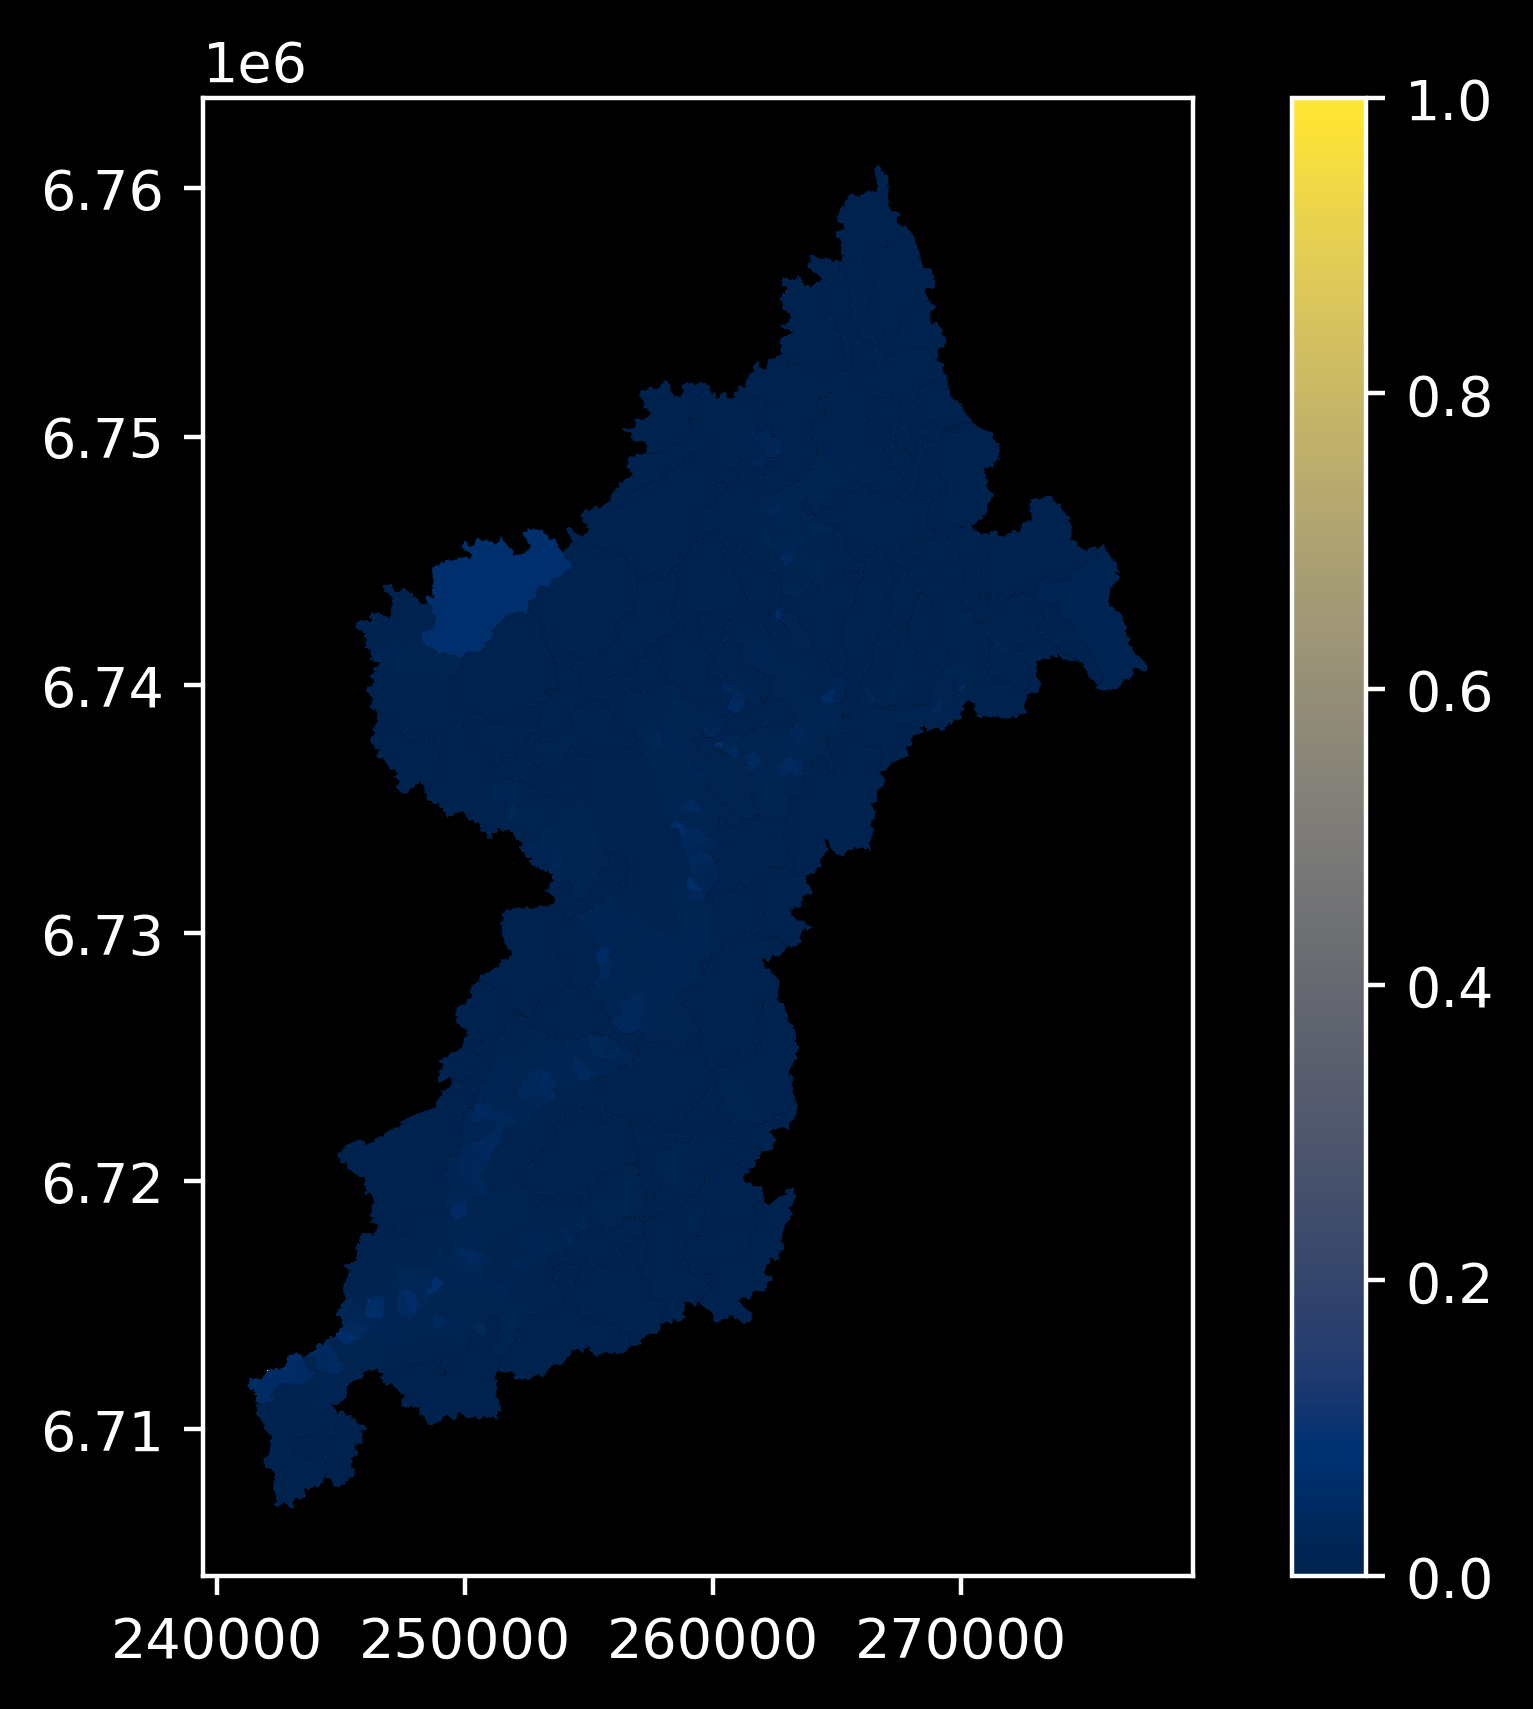

In [38]:
ax = subwatersheds.plot("water_portion", markersize=0.2, cmap='cividis', legend=True)
ax = subwatersheds.loc[[82]].plot(ax=ax, linewidth=10, color="red")

In [6]:
subwatersheds

,Paikka_Id,main_basin_index,area_m2,id,pituus_m,next,pour,dam,in_connect,lake,geometry
0,1117,15,4938400.0,8,507.992178,440,False,False,0,False,"POLYGON ((267820 6758350, 267820 6758320, 2677..."
1,1117,15,1545400.0,440,504.263528,442,False,False,1,False,"POLYGON ((268240 6756290, 268240 6756280, 2682..."
2,1117,15,747300.0,442,504.401821,444,False,False,1,False,"POLYGON ((266430 6755070, 266430 6755040, 2664..."
3,1117,15,1663200.0,430,536.981043,432,False,False,1,False,"POLYGON ((264150 6756250, 264150 6756240, 2641..."
4,1117,15,2351600.0,428,472.993076,430,False,False,0,False,"POLYGON ((263400 6756500, 263400 6756490, 2633..."
...,...,...,...,...,...,...,...,...,...,...,...
488,1117,15,655200.0,514,561.501809,516,False,False,1,False,"POLYGON ((244230 6709040, 244230 6709030, 2442..."
489,1117,15,1944100.0,520,496.362766,522,False,False,1,False,"POLYGON ((241880 6711070, 241880 6711060, 2418..."
490,1117,15,3701100.0,512,481.872360,514,False,False,1,False,"POLYGON ((244980 6710760, 244980 6710750, 2449..."
491,1117,15,1062500.0,516,514.730314,518,False,False,1,False,"POLYGON ((243120 6708740, 243120 6708730, 2431..."


In [34]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 35989, 'height': 61978, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(20.0, 0.0, 20000.0,
       0.0, -20.0, 7836760.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

<Axes: >

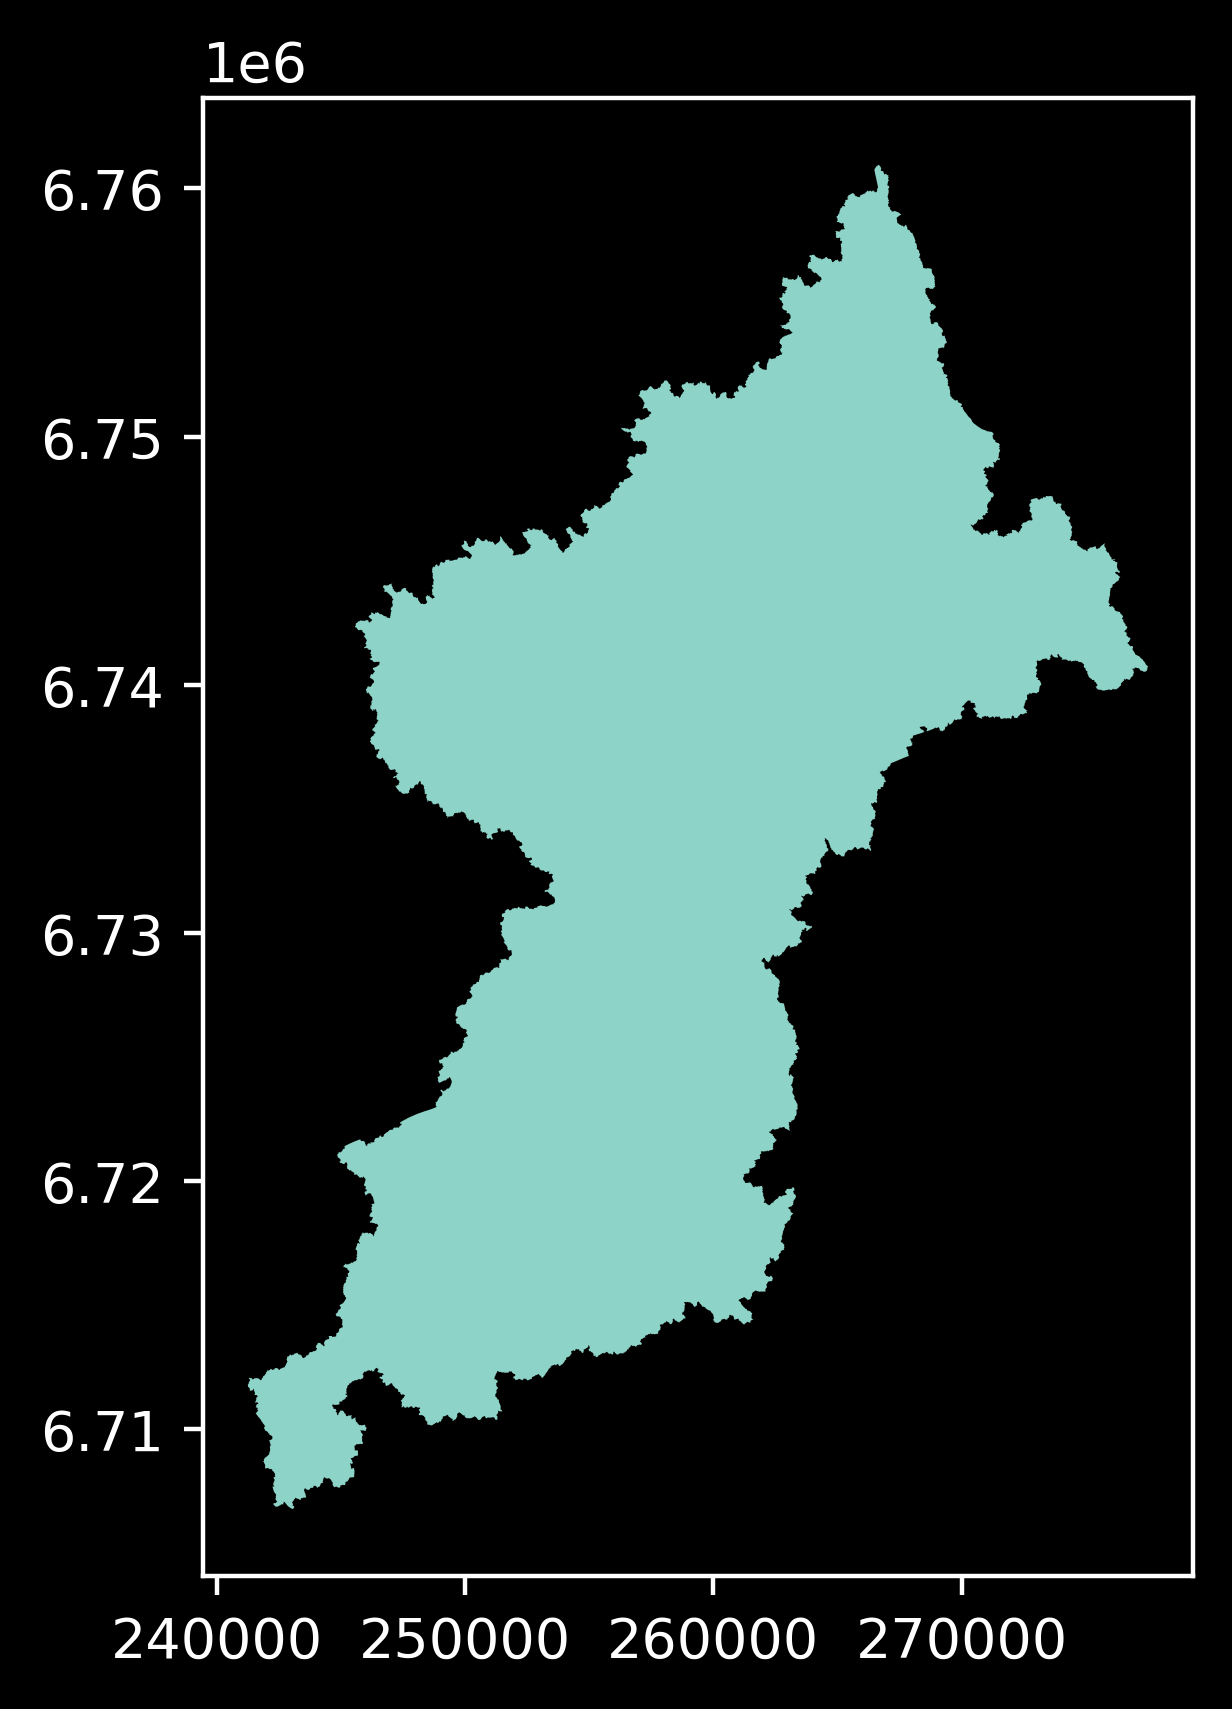

In [35]:
watershed.plot()